In [1]:
from torch_geometric.datasets import MoleculeNet
import torch
import numpy as np
import pandas as pd
from sklearn import metrics
import models

## Import Dataset

In [2]:
train_data = MoleculeNet(root="/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/split_bace/train", name="bace")
test_data = MoleculeNet(root="/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/split_bace/test", name="bace")

In [3]:
len(test_data)

303

In [4]:
#Specify device
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Set Hyperparameters

In [5]:
import best_config
from torch_geometric.data import DataLoader
#Get Model Parameters
NUM_GRAPHS_PER_BATCH = 64
train_loader = DataLoader(train_data, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(test_data, 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


/home/rajeckidoyle/miniconda3/envs/my_torch_geometric/lib/python3.8/site-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


## Define Model

## Training Loop

In [6]:
from torch_geometric.data import DataLoader
import warnings
warnings.filterwarnings("ignore")

# Root mean squared error
loss_fn = torch.nn.BCELoss()

model_this_run = 'GAT'

hyperparameters = eval('best_config.'+model_this_run+'_HYPERPARAMETERS')
model_params = hyperparameters
model_params['feature_size'] = train_data.num_features
model_params['no_of_heads'] = 3
model_params["edge_dim"] = train_data[0].edge_attr.shape[1]

def train(model, optimizer, loader):
    model.train()
    # Enumerate over the data
    final_loss = 0
    for batch in loader:
      # Use GPU
      batch.to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      if model_params['has_edge_info']:
          pred = model(batch.x.float(),
                        batch.edge_attr.float(), 
                        batch.edge_index, 
                        batch.batch)
      else:
          pred = model(batch.x.float(), 
                        batch.edge_index, 
                        batch.batch)
      # Calculating the loss and gradients
      loss = loss_fn(pred, batch.y)
      final_loss += loss.item()
      loss.backward()
      # Update using the gradients
      optimizer.step()   
    return final_loss / len(loader)

def get_results(binary_results):
    accuracy = metrics.accuracy_score(binary_results["y_real"],binary_results["y_pred"])
    f1 = metrics.f1_score(binary_results["y_real"],binary_results["y_pred"])
    precision = metrics.precision_score(binary_results["y_real"],binary_results["y_pred"])
    recall = metrics.recall_score(binary_results["y_real"],binary_results["y_pred"])
    roc_auc = metrics.roc_auc_score(binary_results["y_real"],binary_results["y_pred"])
    tn, fp, fn, tp = metrics.confusion_matrix(binary_results["y_real"],binary_results["y_pred"], labels=[0,1]).ravel()
    specificity = tn / (tn+fp)

    results = {
        'Accuracy':accuracy,
        'F1': f1,
        'Precision': precision,
        'Recall': recall,
        'ROCAUC': roc_auc,
        'Specificity': specificity,
        'TN': tn,
        'FP': fp,
        'FN': fn,
        "TP": tp,
    }
    return results

def test(model, test_loader):
    model.eval()
    true_values = []
    predictions = []
    with torch.no_grad():
        for batch in test_loader:
            batch.to(device)
            if model_params['has_edge_info']:
                pred = model(batch.x.float(),
                                batch.edge_attr.float(), 
                                batch.edge_index, 
                                batch.batch)
            else:
                pred = model(batch.x.float(), 
                                batch.edge_index, 
                                batch.batch)
            true_values += batch.y.tolist()
            predictions += pred.tolist()
    df = pd.DataFrame({'y_pred':predictions,'y_real':true_values})
    df = df.applymap(lambda x : x[0])
    output = df["y_pred"].apply(lambda x: int(round(x,0)))
    output
    binary_results = df.applymap(lambda x : int(round(x,0)))
    binary_results
    return df, binary_results, output, get_results(binary_results)

    

In [7]:
summary_columns = {
    'Accuracy':[],
    'F1': [],
    'Precision': [],
    'Recall': [],
    'ROCAUC': [],
    'Specificity': [],
    'TN': [],
    'FP': [],
    'FN': [],
    "TP": [],
}
summary = pd.DataFrame(summary_columns)

best_acc = 0

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/'


for i in range(10):
    torch.manual_seed(i)
    print(f"Starting training run {i}")
    #Create instance of model
    model = eval('models.'+model_this_run+'(model_params)')
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=model_params['learning_rate'])
    for epoch in range(300):
        loss = train(model, optimizer, train_loader)
    _, _, _, results = test(model, test_loader)
    if results['Accuracy'] > best_acc:
        best_acc = results['Accuracy']
        torch.save(model.state_dict(), filepath+'best_models/'+model_this_run+'_model.pt')
    results_this_run = pd.DataFrame([results])
    summary = summary.append(results_this_run)


summary.to_csv(filepath + 'results/'+model_this_run+'summary.csv')
summary
    

Starting training run 0
Starting training run 1
Starting training run 2
Starting training run 3
Starting training run 4
Starting training run 5
Starting training run 6
Starting training run 7
Starting training run 8
Starting training run 9


,Accuracy,F1,Precision,Recall,ROCAUC,Specificity,TN,FP,FN,TP
0,0.735974,0.611650,0.787500,0.500000,0.701977,0.903955,160.0,17.0,63.0,63.0
0,0.755776,0.663636,0.776596,0.579365,0.730361,0.881356,156.0,21.0,53.0,73.0
0,0.765677,0.628272,0.923077,0.476190,0.723971,0.971751,172.0,5.0,66.0,60.0
0,0.765677,0.660287,0.831325,0.547619,0.734262,0.920904,163.0,14.0,57.0,69.0
0,0.752475,0.641148,0.807229,0.531746,0.720675,0.909605,161.0,16.0,59.0,67.0
0,0.745875,0.631579,0.795181,0.523810,0.713882,0.903955,160.0,17.0,60.0,66.0
0,0.762376,0.650485,0.837500,0.531746,0.729150,0.926554,164.0,13.0,59.0,67.0
0,0.739274,0.577540,0.885246,0.428571,0.694512,0.960452,170.0,7.0,72.0,54.0
0,0.712871,0.508475,0.882353,0.357143,0.661622,0.966102,171.0,6.0,81.0,45.0
0,0.765677,0.666667,0.816092,0.563492,0.736548,0.909605,161.0,16.0,55.0,71.0


## Evaluate on the Test Set

## Model Evaluation

In [8]:
model = eval('models.'+model_this_run+'(model_params)')
model.load_state_dict(torch.load(f'/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/best_models/{model_this_run}_model.pt'))
model = model.to(device)

df, binary_results, output, results = test(model, test_loader)

print(model)

GAT(
  (conv_layers): ModuleList(
    (0): GATConv(3072, 1024, heads=3)
    (1): GATConv(3072, 1024, heads=3)
    (2): GATConv(3072, 1024, heads=3)
  )
  (initial_conv): GATConv(9, 1024, heads=3)
  (gnn_dropout): Dropout(p=0.112, inplace=False)
  (linear_dropout): Dropout(p=0.0586, inplace=False)
  (linear): Linear(in_features=6144, out_features=64, bias=True)
  (out): Linear(in_features=64, out_features=1, bias=True)
)


### Confusion Matrix

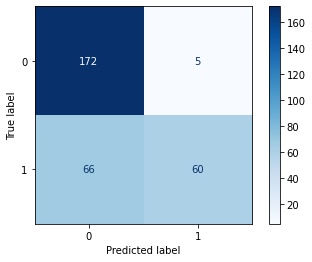

In [9]:
import matplotlib.pyplot as plt
labels = [0,1]
cm = metrics.confusion_matrix(output,df["y_real"])
metrics.ConfusionMatrixDisplay.from_predictions(binary_results["y_real"],binary_results["y_pred"], cmap='Blues')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + model_this_run + 'confusion_matrix.jpeg', bbox_inches='tight',dpi=100)

### ROC Curve

In [10]:
r_fpr, r_tpr, thresholds = metrics.roc_curve(df["y_real"].to_list(),df["y_pred"].to_list())

roc_curve_data = pd.DataFrame({'r_fpr': r_fpr, 'r_tpr': r_tpr, 'thresholds': thresholds})

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
roc_curve_data.to_csv(filepath + model_this_run+'rocdata.csv')

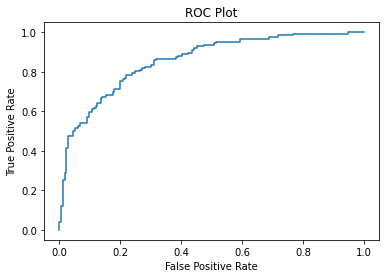

In [11]:
import matplotlib.pyplot as plt

plt.plot(r_fpr, r_tpr)
# Title
plt.title('ROC Plot')
# Axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + model_this_run + 'roc_curve.jpeg', bbox_inches='tight', dpi=100)

## PR Curve

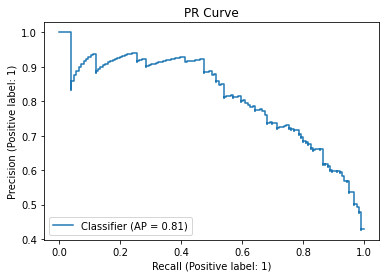

In [12]:
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(df["y_real"].to_list(),df["y_pred"].to_list())
metrics.PrecisionRecallDisplay.from_predictions(df["y_real"].to_list(),df["y_pred"].to_list())

plt.title('PR Curve')

filepath = '/home/rajeckidoyle/Documents/Classification/BACE_Classification/model_benchmarks/results/'
plt.savefig(filepath + model_this_run + 'pr_curve.jpeg', bbox_inches='tight', dpi=100)